# DS Final Assignment: Traffic Volume Congestion Classification

Myat Ma De May Phuu Ngon

---

## Project Overview

This notebook trains three classifiers to predict traffic congestion level into three groups (low, mid, high) with hourly data collected from Japan's national highway API.

### Objectives
1. Understand the domain and data collection
2. Conduct exploratory data analysis (EDA) for discovering patterns in the data.
3. Engineer features and preprocessing given data
4. Train baseline models: Random Forest, SVM, and advanced model: MLP and compare
5. Evaluate models using appropriate metrics

---
## Importing Libraries

In [1]:
# Manipulation of data
import pandas as pd                    
import numpy as np                    
import copy



# For visualization
import matplotlib.pyplot as plt       
import seaborn as sns                  

# Model selection, evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, precision_score, recall_score)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

# Models
from sklearn.ensemble import RandomForestClassifier    
from sklearn.svm import SVC                            
from sklearn.neural_network import MLPClassifier       

# Deep Learning
import tensorflow as tf

# Utility
import warnings
warnings.filterwarnings('ignore')      

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

/opt/anaconda3/envs/ds/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


---
## Data Loading and Initial Exploration

We loaded the already processed traffic dataset for modelling. We tried to explore its structure, check for missing values, and see the data to do analysis.

**Functions used:**

- `df.read_csv(file)`: This opens a CSV file 
- `df.to_datetime()`: This converts text like "202509221400" into actual date/time
- `df.to_numeric()`: This converts text numbers to actual numbers
- `df.sort_values()`: This is for arranging data in order like date
- `df.dropna()`: This is for removing rows with missing values
- `df.isnull().sum()`: This is for counting how many missing values we have in the dataset

- `df.head()`: for showing first 5 rows of the data
- `df.shape`: for showing how many number of rows and columns
- `df.describe()`: for showing basic statistics like average, min, max
- `df.value_counts()`: for counting how many times a certain value appears

In [2]:
# Load the dataset
df = pd.read_csv('Traffic_data_JP.csv')

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nDataset Shape: {df.shape[0]} rows x {df.shape[1]} columns")  # size of table
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")   


DATASET OVERVIEW

Dataset Shape: 8540 rows x 37 columns
Memory Usage: 5.44 MB


In [3]:
# We need to see if datetime column is correctly parsed/ data sorted chronologically
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)
print('Datetime column converted and DataFrame sorted by datetime.')

Datetime column converted and DataFrame sorted by datetime.


In [4]:
# We displayed first few rows to see how the data looks like
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,FID,地方整備局等番号,開発建設部／都道府県コード,常時観測点コード,収集時間フラグ（5分間／1時間）,観測年月日,時間帯,上り・小型交通量,上り・大型交通量,上り・車種判別不能交通量,...,hour,dayofweek,is_weekend,hour_sin,hour_cos,station_6110080,station_6110090,station_6110100,station_6110530,congestion_class
0,t_travospublic_measure_1h.6884261,86,NaN,6110080,2,20250922,0,217,69,0,...,0,0,0,0.000000,1.000000,True,False,False,False,low
1,t_travospublic_measure_1h.6884262,86,NaN,6110090,2,20250922,0,342,93,0,...,0,0,0,0.000000,1.000000,False,True,False,False,low
2,t_travospublic_measure_1h.6884263,86,NaN,6110100,2,20250922,0,102,27,0,...,0,0,0,0.000000,1.000000,False,False,True,False,low
3,t_travospublic_measure_1h.6884303,86,NaN,6110530,2,20250922,0,164,40,0,...,0,0,0,0.000000,1.000000,False,False,False,True,low
4,t_travospublic_measure_1h.6885374,86,NaN,6110080,2,20250922,100,178,101,0,...,1,0,0,0.258819,0.965926,True,False,False,False,low


In [5]:
# Missing values check
# Counts nulls per column and prints either a no missing value message or the columns with missing data.
print("\nMissing Values Analysis:")
print("-" * 40)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found in the dataset!")
else:
    print(missing[missing > 0])



Missing Values Analysis:
----------------------------------------
開発建設部／都道府県コード    8540
dtype: int64


The missing "開発建設部／都道府県コード" doesn't matter because we already set to Osaka, Ibaraki, Japan and we do not use this for classification task.

---
## Exploratory Data Analysis (EDA)

Next, we explored the dataset to see how our classes are distributed, find some temporal patterns, and how they relate to each other. This is important because depending on this, we can proceed with feature engineering and model selection by looking at the discovered trends.

First, we looked at the distribution of the target variable (`congestion_class`) which was already made in other notebook. Here, we only try to see if there is class imbalance.

Congestion class was made by using global quantiles of total volume. Total volume was calculated by summing 上り・小型交通量 (upbound small cars volume), 上り・大型交通量 (upbound big cars volume), 下り・小型交通量 (downbound small cars volume), 下り・大型交通量 (downbound big cars volume). Therefore, the first quantile of total volume is labeled as 'low', second quantile is 'medium', and the last quantile is 'high'.

### Visualization Functions

- `plt.subplots(figsize=(10, 5))`: This makes a blank canvas for drawing (10 wide, 5 tall)
- `plt.plot()`: Drawing a line graph (for trends over time)
- `plt.bar()`: Drawing a bar chart (for comparing categories)
- `plt.hist()`: Drawing a histogram (for distribution of values)
- `plt.boxplot()`: Drawing a box plot (shows min, max, median, quartiles)
- `plt.fill_between()`: This fills area between lines just to make graphs prettier

- `sns.heatmap()`: This heatmap just makes a colorful grid to show correlation between features (darker/ warmer color for stronger relationships)

**Parameters:**
- `figsize=(10, 5)`: Size of the plot (width, height)
- `alpha=0.5`: Transparency (0 = invisible, 1 = solid)
- `color='#3498db'`: Color of the plot
- `label='...'`: Legend label for the line/bar
- `title='...'`: Title of the plot
- `xlabel`, `ylabel`: Labels for axes

Target Variable Distribution (congestion_class):
----------------------------------------
low: 2847 samples (33.34%)
high: 2847 samples (33.34%)
medium: 2846 samples (33.33%)


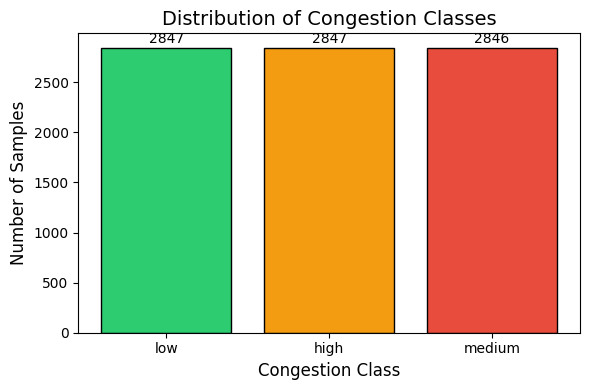

In [6]:
# Target variable distribution
# Shows class counts and a bar chart to see class balance
print("Target Variable Distribution (congestion_class):")
print("-" * 40)
class_dist = df['congestion_class'].value_counts()
class_pct = df['congestion_class'].value_counts(normalize=True) * 100

for cls in class_dist.index:
    print(f"{cls}: {class_dist[cls]} samples ({class_pct[cls]:.2f}%)")

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(class_dist.index, class_dist.values, color=['#2ecc71', '#f39c12', '#e74c3c'], edgecolor='black')
ax.set_xlabel('Congestion Class', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Distribution of Congestion Classes', fontsize=14)
for bar, val in zip(bars, class_dist.values):  # label bars with counts
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, str(val), ha='center')
plt.tight_layout()
plt.show()


According to the graph and result above, we do have a very small class imbalance but it's just one so we will leave it at that.

### Temporal Pattern Analysis

Secondly, we visualized how traffic volume changes each hour and days of the week. According to our literature review, we need these time and day data patterns and these surely would contribute to the traffic volume prediction. The goal here is to reveal rush hours, weekday/weekend effects.

In the other notebook, we converted the 時間コード (time code) column to proper datetime format (e.g: 202509221400 = Sept 22, 2025, 14:00) and created as new column 'datetime'. Then, we created 'hour', 'dayofweek' and 'is_weekend' columns. 'hour' column ranges from 0 to 23. 'dayofweek' column has 0 for Monday, 6 for Sunday and etc. Both were calculated from 'datetime' 'is_weekend' column was based on 'dayofweek' column and has value of 1 if the day is either Saturday or Sunday.

Next, there is an issue with hour (0-23), where hour 23 and hour 0 are adjacent but numerically far apart. Therefore, the solution is to map the hours into a circle using sine/ cosine. The cyclical nature would preserve the time for the model.

Regarding the station one-hot encoding, categorical station IDs from the raw data were converted into binary columns of station_~~~, etc. This is to make each row to have a '1' in its corresponding station column, and '0' in other stations.

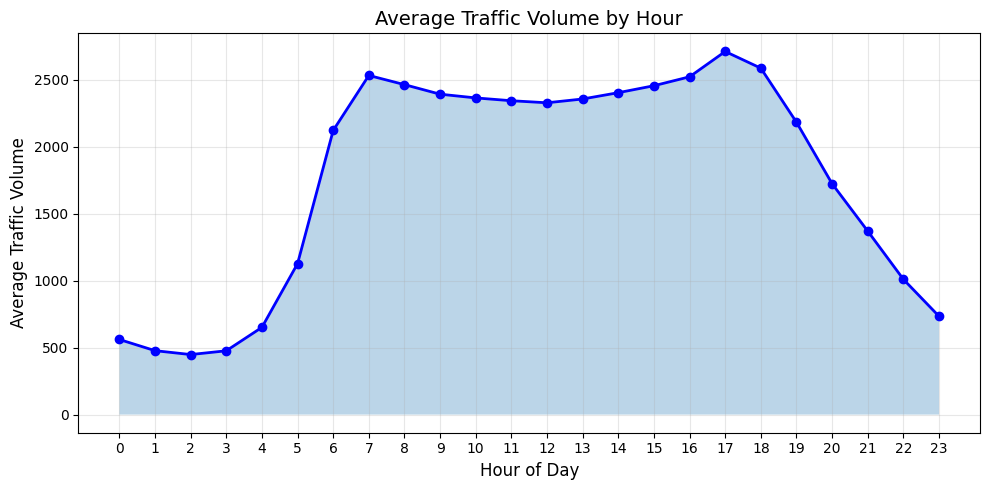

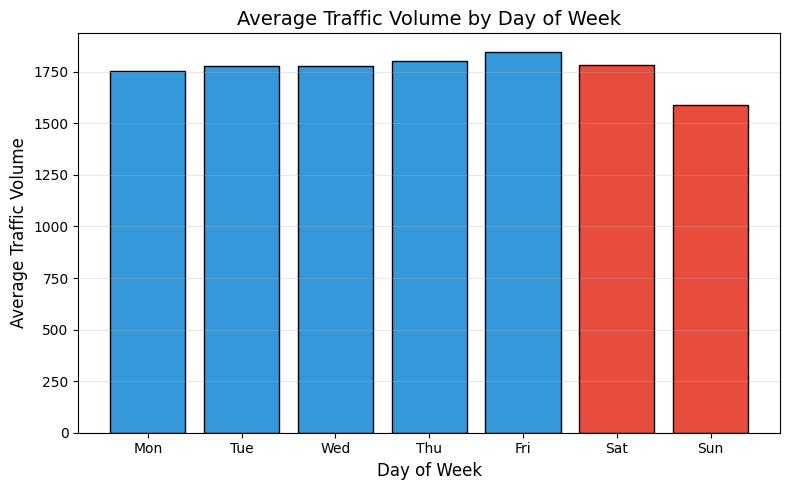

In [7]:
# Average traffic volume by hour visualization to show trend
hourly_volume = df.groupby('hour')['total_volume'].mean()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hourly_volume.index, hourly_volume.values, 'b-o', linewidth=2, markersize=6)
ax.fill_between(hourly_volume.index, hourly_volume.values, alpha=0.3)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Average Traffic Volume', fontsize=12)
ax.set_title('Average Traffic Volume by Hour', fontsize=14)
ax.set_xticks(range(0, 24))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Average traffic volume visualization to show weekday/weekend effects
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_volume = df.groupby('dayofweek')['total_volume'].mean()
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(range(7), daily_volume.values, color=['#3498db']*5 + ['#e74c3c']*2, edgecolor='black')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Average Traffic Volume', fontsize=12)
ax.set_title('Average Traffic Volume by Day of Week', fontsize=14)
ax.set_xticks(range(7))
ax.set_xticklabels(day_names)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In the first figure, we can see a general trend of congestion. Traffic tends to increase starting from 6:00 and from 7:00 to 18:00, it remains high, with peak at 17:00. After 18:00, the traffic volume goes down again.

In the second figure, Fridays have the most traffic and Sunday, the least.

If we refer back to the literature review, the trends are generally similar.

### Traffic Volume Distribution

Next, we investigated the distribution of total traffic volume and hour, sorted in congestion class. This is for understanding how congestion levels are related to our observed data on traffic and time.

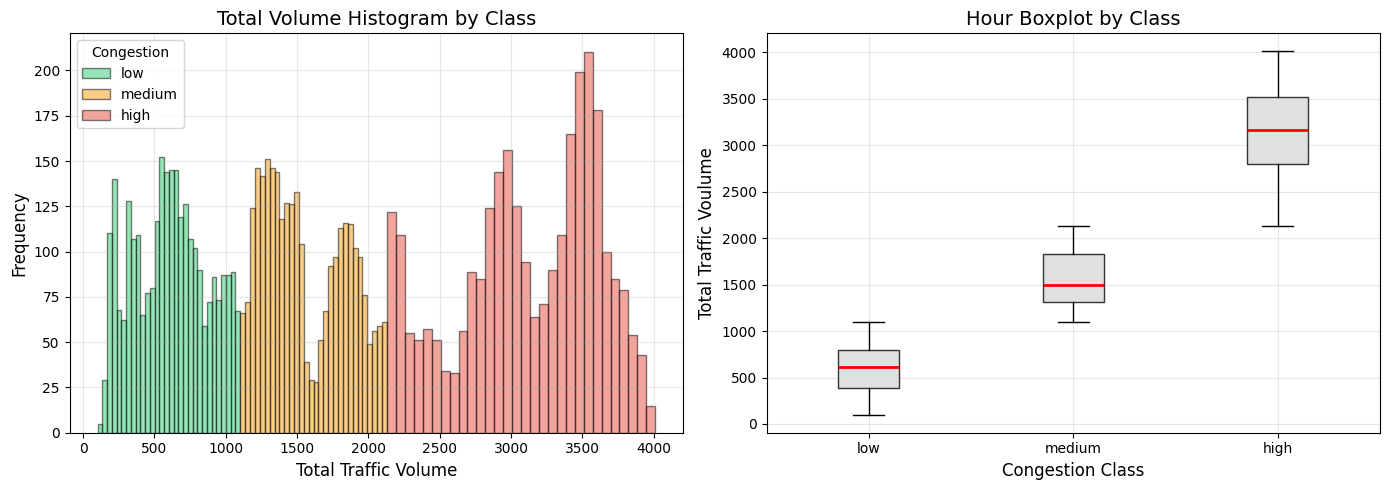

In [8]:
# Distributions by class
# Left: histogram of total volume per class; Right: boxplot of volume spread per class.
class_order = ['low', 'medium', 'high']
colors = ['#2ecc71', '#f39c12', '#e74c3c']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total volume distribution by class
for cls, color in zip(class_order, colors):
    axes[0].hist(df[df['congestion_class']==cls]['total_volume'], bins=30, alpha=0.5, label=cls, color=color, edgecolor='black')
axes[0].set_xlabel('Total Traffic Volume', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Total Volume Histogram by Class', fontsize=14)
axes[0].legend(title='Congestion')
axes[0].grid(True, alpha=0.3)

# Boxplot of total volume by class to understand some summary stats
hour_data = [df[df['congestion_class']==cls]['total_volume'] for cls in class_order]
axes[1].boxplot(hour_data, labels=class_order, patch_artist=True, boxprops=dict(facecolor='#e0e0e0', color='#333'), medianprops=dict(color='red', linewidth=2))
axes[1].set_xlabel('Congestion Class', fontsize=12)
axes[1].set_ylabel('Total Traffic Voulume', fontsize=12)
axes[1].set_title('Hour Boxplot by Class', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


On visualization of the first figure here, we can see the frequency of volume for each class. For the 'low' congestion class, the most frequent volume is around 600-700, while for 'medium', it is around 1200-1300. For 'high' class, the higest frequncy of traffic volume is around 3600.

The second figure reveals the average, quantiles of traffic volume for each class. This is similar to the first plot but a little easier to see.

### Correlation Analysis

After looking into our main labelled data, we want to know the correlations among these features. This is crucial to detect less important features and have an informed decision for feature selection.

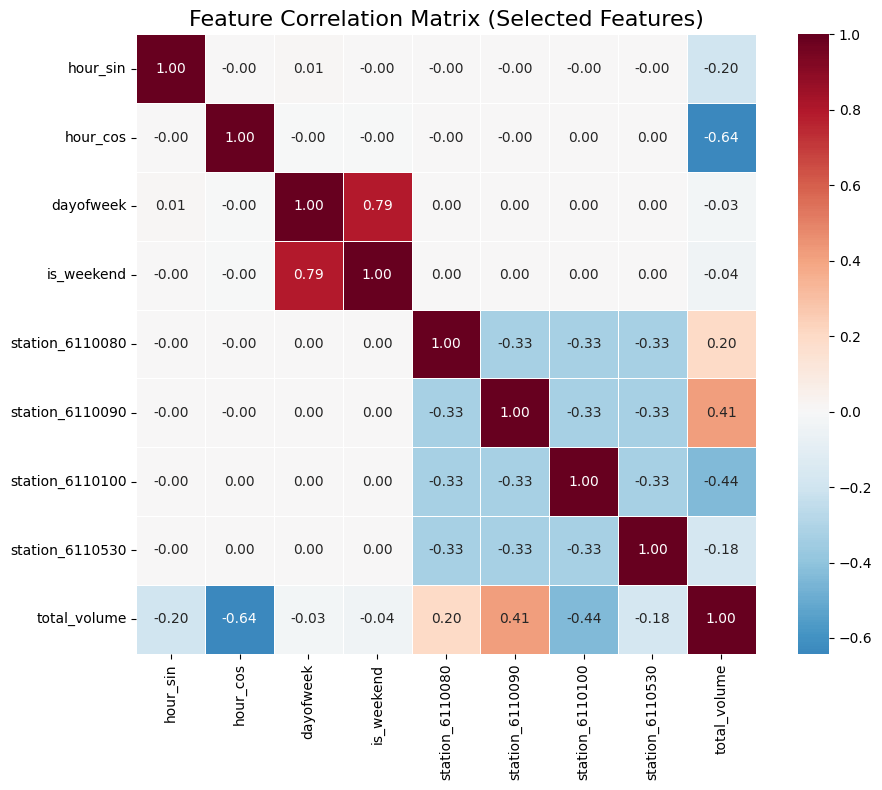

In [9]:
# Correlation analysis of selected features with total_volume
# Helps identify linear relationships which is necessary for finding feature relevance
feature_columns_corr = [
    'hour_sin',
    'hour_cos',
    'dayofweek',
    'is_weekend',
    'station_6110080',
    'station_6110090',
    'station_6110100',
    'station_6110530',
    'total_volume'
]
correlation_matrix = df[feature_columns_corr].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, fmt='.2f', ax=ax)
ax.set_title('Feature Correlation Matrix (Selected Features)', fontsize=16)

plt.tight_layout()
plt.show()


We mainly focused on the total_volume and selected features. There are some weak dependencies observed.

---
## Data Preprocessing

We now moved to the next step which is preparing the data for modeling. We select our prepared features. We also created the feature matrix and target vector, and split the data chronologically to prevent lookahead bias.

### Functions used

- `pd.get_dummies(column)`: This is for converting categories into binary columns (e.g., as mentioned earlier, we want station IDs to be into multiple 0/1 columns)
- `pd.concat([df1, df2])`: This is for combining to add new column
- `pd.cut(values, bins, labels)`: This is used to divides continuous numbers into groups/classes (e.g: low/medium/high)
- `df.groupby('column').mean()`: This is to group data by a certain column and calculates average/mean for that group
- `np.sin()`, `np.cos()`: Math functions for converting linear hour values into circular/cyclical values so that values of '23' and '0' are not apart

- `StandardScaler()`: This is to normalize features so that they are all on same scale (0 mean, 1 std). Without this, features with larger numbers would dominate and this would hurt model like SVM

- `LabelEncoder()`: This is for encoding the labels. It converts text labels like "low", "medium", "high" into numbers 0, 1, 2, our models only understand numbers, not text

In [10]:
# Select features for modeling as inputs
feature_columns = [
    'hour_sin',         # Cyclical hour (sine)
    'hour_cos',         # Cyclical hour (cosine)
    'dayofweek',        # Day of week (0=Monday, 6=Sunday)
    'is_weekend',       # Weekend indicator (0=weekday, 1=weekend)
    'station_6110080',  # One-hot station columns
    'station_6110090',
    'station_6110100',
    'station_6110530'
]

print(f"Features selected ({len(feature_columns)}):")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i}. {feat}")


Features selected (8):
  1. hour_sin
  2. hour_cos
  3. dayofweek
  4. is_weekend
  5. station_6110080
  6. station_6110090
  7. station_6110100
  8. station_6110530


In [11]:
# Prepare feature matrix (X) and target vector (y)
# X: model inputs, y: labels to predict
X = df[feature_columns].copy()
y = df['congestion_class'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Feature matrix shape: (8540, 8)
Target vector shape: (8540,)


In [12]:
# Chronological train-test split
# We keep the first 80% (earlier timestamps) for training, 
# and remaining 20% (later timestamps) for testing to prevent lookahead bias.

split_idx = int(len(X) * 0.8)  # index separating train/test by time

# Feature matrix slices to preserve chronological order
X_train = X.iloc[:split_idx]   # rows up to split index is for training set
X_test  = X.iloc[split_idx:]   # rows from split index onward is for test set

# Target label slices (aligned with feature slices)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

# Report the split sizes for check
print("Data Split Summary (Chronological):")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Testing set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")


Data Split Summary (Chronological):
  Training set: 6832 samples (80.0%)
  Testing set:  1708 samples (20.0%)


In [13]:
# Feature scaling
# Standardize features (0 mean, 1 std) for models (SVM/MLP) sensitive to scale
# Random Forest is scale-invariant, but we keep consistency
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit on train, transform train
X_test_scaled = scaler.transform(X_test)         # transform test with same stats

print("Feature Scaling Complete!")
print(f"  Scaled mean: {X_train_scaled.mean():.6f}")
print(f"  Scaled std:  {X_train_scaled.std():.6f}")


Feature Scaling Complete!
  Scaled mean: -0.000000
  Scaled std:  1.000000


## Model Training

Now, we train our models for future classification prediction on traffic volume with the selected features.

We used the classifier term and it basically means a model that learns to predict which category something belongs to. For our dataset, is traffic "low"/ "medium"/ "high"? 

### Baseline: Random Forest Classifier

Random Forest is a method that builds multiple decision trees and outputs the mode of their predictions. It is robust to feature scaling and handles class imbalance well with the `class_weight` parameter.

**Parameters:**

- `n_estimators`: This is about the number of trees in Random Forest classifier
- `max_depth`: This tells how deep each tree can grow in Random Forest
- `kernel='rbf'`: This is for setting type of boundary (rbf = non-linear)
- `hidden_layer_sizes=(128, 64, 32)`: This is for setting number of neurons in each layer in MLP
- `learning_rate`: This is for setting the speed like how fast the model learns in MLP

In [14]:
# Train Random Forest
print("Training Random Forest Classifier...")
print("=" * 50)

rf_model = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=15,          # maximum tree depth to reduce overfitting
    min_samples_split=5,   # split threshold
    min_samples_leaf=2,    # minimum samples per leaf
    class_weight='balanced',  # handle slight class imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1              # use all cores
)

rf_model.fit(X_train, y_train)
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

print("Training complete!")


Training Random Forest Classifier...
Training complete!


In [15]:
# Evaluate Random Forest
# Reports accuracy and a detailed classification report on test set
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

# Define class_names from unique sorted labels in y_test
class_names = sorted(list(set(y_test)))

print("\nRandom Forest Performance:")
print("=" * 50)
print(f"Training Accuracy: {rf_train_acc:.4f}")
print(f"Testing Accuracy:  {rf_test_acc:.4f}")
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, rf_test_pred, target_names=class_names))



Random Forest Performance:
Training Accuracy: 0.9655
Testing Accuracy:  0.9725

Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.98      0.98      0.98       577
         low       0.99      0.96      0.98       564
      medium       0.95      0.97      0.96       567

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708



For our random forest, the average is 0.97%, which is quite high.

We are going to see how each feature contributes below.

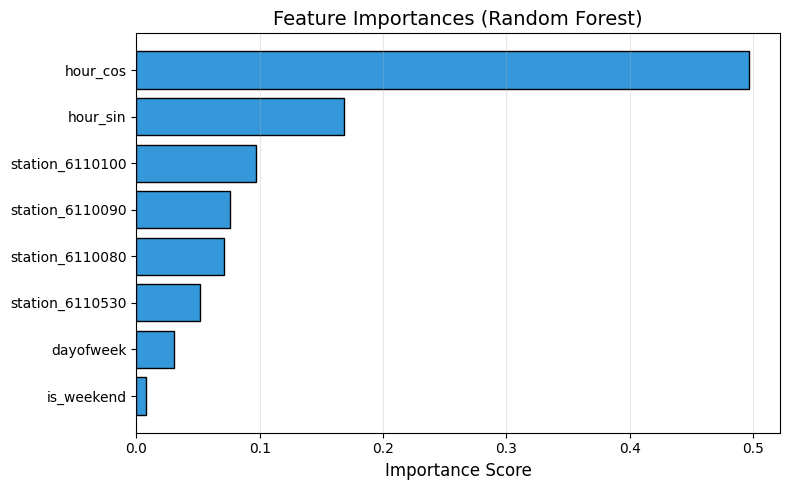


Feature Importance:
  hour_cos: 0.4969
  hour_sin: 0.1686
  station_6110100: 0.0972
  station_6110090: 0.0761
  station_6110080: 0.0707
  station_6110530: 0.0517
  dayofweek: 0.0309
  is_weekend: 0.0079


In [16]:
# Feature importance
# Shows which inputs Random Forest used most for its decisions
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(range(len(feature_columns)), feature_importance['importance'].values, 
               color='#3498db', edgecolor='black')
ax.set_yticks(range(len(feature_columns)))
ax.set_yticklabels(feature_importance['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Feature Importances (Random Forest)', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nFeature Importance:")
for _, row in feature_importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")


The feature that has the most importance is hour_cos with hour_sin in second place. Some stations have importance but we can see that is_weekend does not have that much importance.

### Baseline: Support Vector Machine (SVM)

After random forest, we tried Support Vector Machin. SVM finds the optimal hyperplane that maximizes the margin between classes. It is sensitive to feature scaling and can be effective for well-separated classes.

In [17]:
# Train SVM
# It benefits from scaled features and RBF kernel captures non-linear boundaries
print("Training SVM Classifier...")
print("=" * 50)

svm_model = SVC(
    C=1.0,              # regularization strength
    kernel='rbf',       # non-linear kernel
    gamma='scale',      # kernel width (auto-scaled)
    class_weight='balanced',
    random_state=RANDOM_STATE
)

svm_model.fit(X_train_scaled, y_train)
svm_train_pred = svm_model.predict(X_train_scaled)
svm_test_pred = svm_model.predict(X_test_scaled)

print("Training complete!")


Training SVM Classifier...
Training complete!


In [18]:
# Evaluate SVM
# Reports accuracy and a detailed classification report on test set
svm_train_acc = accuracy_score(y_train, svm_train_pred)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

print("\nSVM Performance:")
print("=" * 50)
print(f"Training Accuracy: {svm_train_acc:.4f}")
print(f"Testing Accuracy:  {svm_test_acc:.4f}")
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, svm_test_pred, target_names=class_names))



SVM Performance:
Training Accuracy: 0.9470
Testing Accuracy:  0.9485

Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.98      0.92      0.95       577
         low       0.99      0.96      0.98       564
      medium       0.89      0.97      0.93       567

    accuracy                           0.95      1708
   macro avg       0.95      0.95      0.95      1708
weighted avg       0.95      0.95      0.95      1708



SVM's accuracy accounts for 0.95% and is a little lower than Random Forest.

---
## Advanced Model: Neural Networks

After trying out baseline models, we tried to implement and evaluate a Multi-Layer Perceptron (MLP) neural network for our classification.

### Advanced: MLP (Multi-Layer Perceptron)

The MLP is a feedforward neural network with three hidden layers. It is trained on scaled features and uses ReLU activations and softmax output for multi-class classification. Early stopping is applied to prevent overfitting since our dataset is not too large.

In [19]:
# Train MLP
# Trained epoch by epoch
print("Training MLP Neural Network...")
print("=" * 50)

# Encode labels to integers for the classifier
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
classes = np.unique(y_train_encoded)
print("Encoded classes:", le.classes_)

# Internal validation split (10%) from the training portion to monitor generalization
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled,
    y_train_encoded,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=y_train_encoded
)

# Build model and have incremental training via partial_fit
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # 3 hidden layers
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=64,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=1,              # one epoch per fit call
    warm_start=True,         # keep state across calls
    shuffle=True,
    random_state=RANDOM_STATE,
    verbose=False
)

print(f"Architecture: {len(feature_columns)} -> 128 -> 64 -> 32 -> {len(classes)}")

# Manual early stopping based on validation log loss
max_epochs = 200
n_iter_no_change = 15
tol = 1e-4

train_losses = []
val_losses = []

best_val_loss = np.inf
best_params = None
no_improve_count = 0

for epoch in range(1, max_epochs + 1):
    # First call must include classes in partial_fit
    if epoch == 1:
        mlp_model.partial_fit(X_tr, y_tr, classes=classes)
    else:
        mlp_model.partial_fit(X_tr, y_tr)

    # Training loss for current epoch
    train_loss = mlp_model.loss_
    train_losses.append(train_loss)

    # Validation loss (log loss on held-out validation split)
    val_proba = mlp_model.predict_proba(X_val)
    val_loss = log_loss(y_val, val_proba, labels=classes)
    val_losses.append(val_loss)

    # Track the best model by validation loss
    if val_loss < best_val_loss - tol:
        best_val_loss = val_loss
        best_params = (copy.deepcopy(mlp_model.coefs_), copy.deepcopy(mlp_model.intercepts_))
        no_improve_count = 0
    else:
        no_improve_count += 1

    if no_improve_count >= n_iter_no_change:
        print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
        break

# Restore the best weights (lowest validation loss)
if best_params is not None:
    mlp_model.coefs_, mlp_model.intercepts_ = best_params

print(f"\nFinished in {len(train_losses)} epochs")
print(f"Best validation loss: {best_val_loss:.6f}")


Training MLP Neural Network...
Encoded classes: ['high' 'low' 'medium']
Architecture: 8 -> 128 -> 64 -> 32 -> 3
Early stopping at epoch 101 (best val loss: 0.108481)

Finished in 101 epochs
Best validation loss: 0.108481


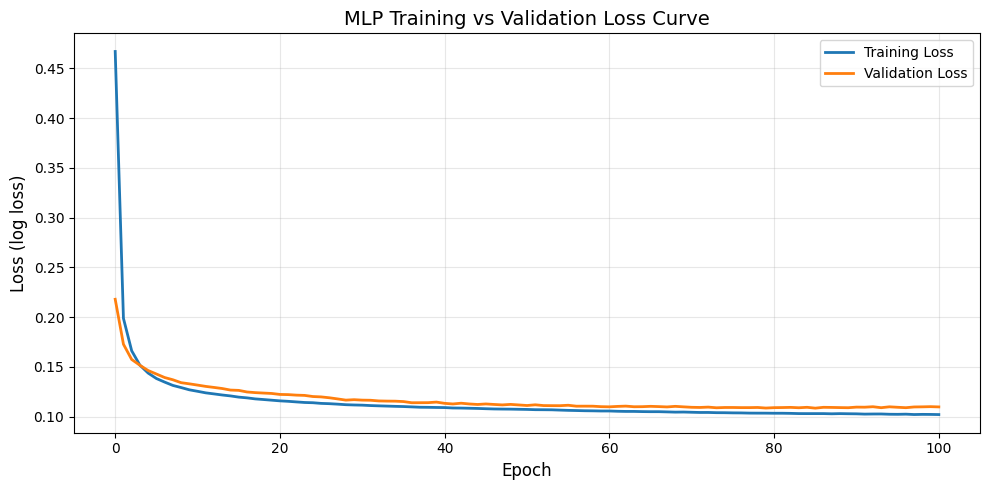

In [20]:
# Plot MLP training & validation loss
# Draws visualization on learning progress across epochs for both train and validation splits to monitor overfitting

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_losses, linewidth=2, label="Training Loss")
ax.plot(val_losses, linewidth=2, label="Validation Loss")

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (log loss)", fontsize=12)
ax.set_title("MLP Training vs Validation Loss Curve", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


The loss curve for training descends rapidly in the first few iterations and stabilized around 30th iteration. The validation loss curve also follows closely with the training loss curve and this means that the model is not overfitting or underfitting.

In [21]:
# Evaluate MLP
# Predict on train and test, then map integer predictions back to original labels
mlp_train_pred = mlp_model.predict(X_train_scaled)
mlp_test_pred = mlp_model.predict(X_test_scaled)

# Decode predictions back to string labels for reporting
mlp_train_pred_labels = le.inverse_transform(mlp_train_pred)
mlp_test_pred_labels = le.inverse_transform(mlp_test_pred)

mlp_train_acc = accuracy_score(y_train, mlp_train_pred_labels)
mlp_test_acc = accuracy_score(y_test, mlp_test_pred_labels)

print("\nMLP Performance:")
print("=" * 50)
print(f"Training Accuracy: {mlp_train_acc:.4f}")
print(f"Testing Accuracy:  {mlp_test_acc:.4f}")
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, mlp_test_pred_labels, target_names=class_names))



MLP Performance:
Training Accuracy: 0.9640
Testing Accuracy:  0.9690

Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.97      0.98      0.98       577
         low       0.99      0.96      0.98       564
      medium       0.94      0.96      0.95       567

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708



The MLP perfomance/ accuracy is quite high (0.97%) like the random forest.

---
## Model Comparison and Evaluation

Now, we compared the performance of all trained models using accuracy, F1 score, precision, and recall. We visualized the results and confusion matrices for easier interpretation and understand the strengths and weaknesses of each approach.

### Evaluation Metrics

The metrics below measure how well our model performs on unseen test data.

1. **Accuracy**
   - Basically means "What percentage of predictions are correct?"
   - Formula: (Correct Predictions) / (Total Predictions)

2. **Precision**
   - This is "When model predicts "high", how often is it actually "high"?"
   - This is to avoid false positives which is saying something is high when it's not
   - Formula: (True Positives) / (True Positives + False Positives)

3. **Recall**
   - This is for saying "When traffic is actually "high", how often does model catch it?"
   - To avoid false negatives like missing the actual high congestion
   - Formula: (True Positives) / (True Positives + False Negatives)

4. **F1 Score**
   - Balanced combination of Precision and Recall
   - Useful when we care about both false positives and false negatives

5. **Confusion Matrix**
   - For easy interpretation of showing all correct and incorrect predictions for each class
   - Diagonal cells show correct predictions
   - Off-diagonal cells are mistakes

**Functions:**
- `accuracy_score(y_true, y_pred)`: Calculates accuracy
- `f1_score()`: Calculates F1 score
- `precision_score()`: Calculates precision
- `recall_score()`: Calculates recall
- `classification_report()`: Shows all metrics in one table
- `confusion_matrix()`: Creates the confusion matrix
- `log_loss()`: Calculates loss (how wrong predictions are, lower is better)

In [22]:
# Comprehensive model comparison
# Put metrics for each model into a row
def evaluate_model(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 (Macro)': f1_score(y_true, y_pred, average='macro'),
        'F1 (Weighted)': f1_score(y_true, y_pred, average='weighted'),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro')
    }

results = []
results.append(evaluate_model(y_test, rf_test_pred, 'Random Forest'))
results.append(evaluate_model(y_test, svm_test_pred, 'SVM'))
results.append(evaluate_model(y_test, mlp_test_pred_labels, 'MLP'))

results_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("FINAL MODEL COMPARISON")
print("=" * 80)
print(results_df.round(4).to_string(index=False))

best_idx = results_df['F1 (Macro)'].idxmax()
best_model = results_df.loc[best_idx, 'Model']
best_f1 = results_df.loc[best_idx, 'F1 (Macro)']
print(f"\n>>> Best Model: {best_model} (F1 Macro: {best_f1:.4f})")



FINAL MODEL COMPARISON
        Model  Accuracy  F1 (Macro)  F1 (Weighted)  Precision  Recall
Random Forest    0.9725      0.9725         0.9726     0.9729  0.9724
          SVM    0.9485      0.9490         0.9489     0.9513  0.9487
          MLP    0.9690      0.9690         0.9691     0.9694  0.9689

>>> Best Model: Random Forest (F1 Macro: 0.9725)


By comparing all the model results, we concluded that the best model was the random forest.

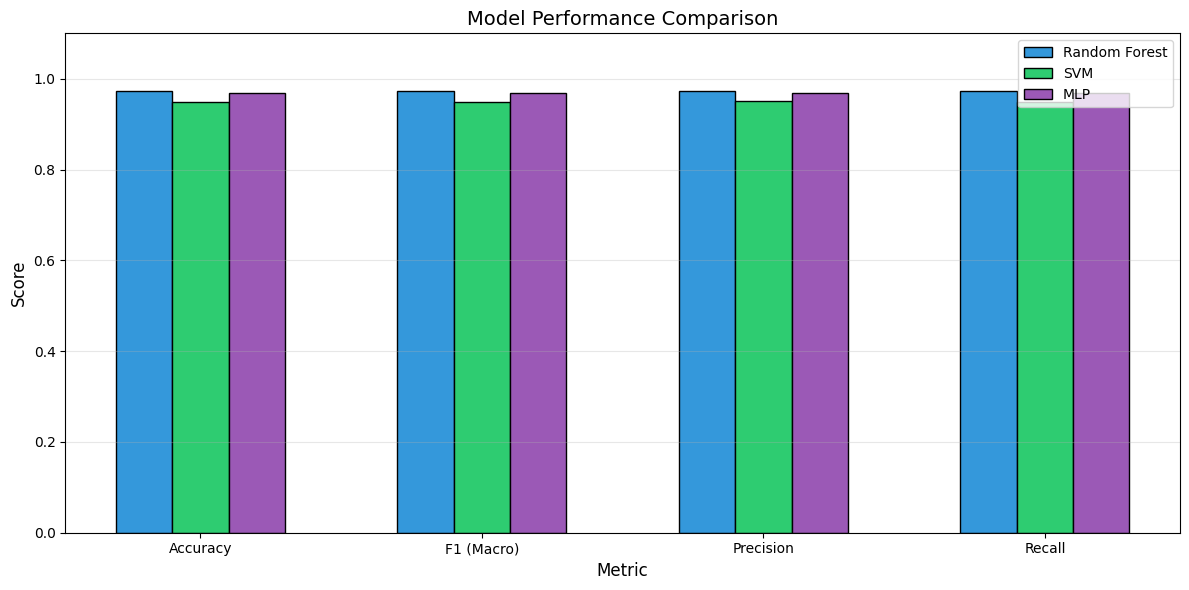

In [23]:
# Visualize model comparison using side-by-side bars for metrics across models
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'F1 (Macro)', 'Precision', 'Recall']
x = np.arange(len(metrics))
width = 0.2

colors = ['#3498db', '#2ecc71', '#9b59b6']
for i, (_, row) in enumerate(results_df.iterrows()):
    values = [row[m] for m in metrics]
    ax.bar(x + i*width, values, width, label=row['Model'], color=colors[i], edgecolor='black')

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


This is just a visualization of each metrics for each model.

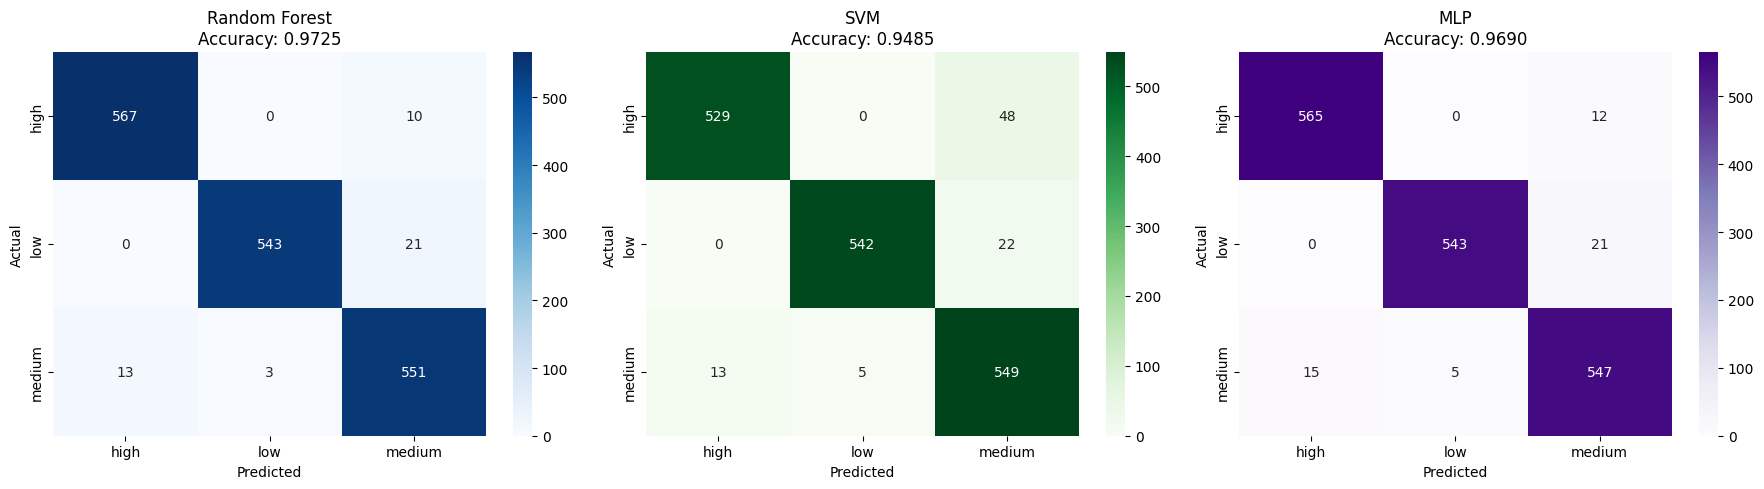

In [24]:
# Confusion matrices for all models to check correct or wrong classification
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('Random Forest', rf_test_pred, rf_test_acc, 'Blues'),
    ('SVM', svm_test_pred, svm_test_acc, 'Greens'),
    ('MLP', mlp_test_pred_labels, mlp_test_acc, 'Purples')
]

for ax, (name, pred, acc, cmap) in zip(axes, models_data):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{name}\nAccuracy: {acc:.4f}')

plt.tight_layout()
plt.show()


The confusion matrix reveals what classes are confused across all models. The diagonal lines are the ones where the predicted and true classes are correct. All models seemed to be confused between low and medium, and medium and high.

---
## Conclusions

This section is just to summarize key results. We highlighted the best-performing model for our data.

In [25]:
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

print("\nTest Set Results for All Models:")
print(results_df[['Model', 'Accuracy', 'F1 (Macro)', 'Precision', 'Recall']].round(4).to_string(index=False))

print("\nBest Model:")
print(f"  {best_model} (Accuracy: {results_df.loc[best_idx, 'Accuracy']:.4f}, F1 Macro: {best_f1:.4f})")
print("\nNotebook execution complete!")


MODEL COMPARISON SUMMARY

Test Set Results for All Models:
        Model  Accuracy  F1 (Macro)  Precision  Recall
Random Forest    0.9725      0.9725     0.9729  0.9724
          SVM    0.9485      0.9490     0.9513  0.9487
          MLP    0.9690      0.9690     0.9694  0.9689

Best Model:
  Random Forest (Accuracy: 0.9725, F1 Macro: 0.9725)

Notebook execution complete!
